
# Redução de Dimensionalidade com PCA — Notebook Didático

**Objetivo:** mostrar, passo a passo, como usar **PCA (Principal Component Analysis)** para reduzir o número de features mantendo **≈95% da variância explicada**, interpretar os resultados e visualizar a variância acumulada.

**Você vai ver:**
1. Por que padronizar os dados antes do PCA;
2. Como escolher o número de componentes via `n_components=0.95`;
3. Como interpretar **variância explicada por componente** e **variância acumulada**;
4. (Opcional) Como usar as *features* transformadas em um modelo de classificação simples.



## 1. Imports e configuração


In [1]:

# Imports principais
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# (Opcional) para a etapa de modelo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Visualização (atenção às regras: usar apenas matplotlib, 1 gráfico por figura e sem estilos/cores específicas)
import matplotlib.pyplot as plt

print('Versões:')
import sys, sklearn
print('Python:', sys.version.split()[0], '| NumPy:', np.__version__, '| Pandas:', pd.__version__, '| scikit-learn:', sklearn.__version__)


Versões:
Python: 3.10.12 | NumPy: 1.26.4 | Pandas: 2.2.3 | scikit-learn: 1.7.1



## 2. Carregar dados e padronizar
**Por que padronizar?** O PCA é sensível à escala: variáveis com escala maior dominam a variância.
Por isso, usamos `StandardScaler` para deixar cada coluna com média 0 e desvio-padrão 1.


In [2]:

# Dataset de exemplo: câncer de mama (569 amostras, 30 features numéricas)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print('Shape original:', X.shape)

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Shape original: (569, 30)



## 3. Aplicar PCA mantendo 95% da variância explicada
Usamos `PCA(n_components=0.95)`: o algoritmo encontra automaticamente o **número mínimo de componentes**
que retém pelo menos **95%** da variância total.


In [3]:

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print('Shape após PCA:', X_pca.shape)
print(f'Variância explicada total: {pca.explained_variance_ratio_.sum():.2%}')

# Tabela de variância por componente
variancia_por_comp = pd.Series(pca.explained_variance_ratio_, index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])
display(variancia_por_comp.to_frame('variancia_explicada'))


Shape após PCA: (569, 10)
Variância explicada total: 95.16%


,variancia_explicada
PC1,0.442720
PC2,0.189712
PC3,0.093932
PC4,0.066021
PC5,0.054958
PC6,0.040245
PC7,0.022507
PC8,0.015887
PC9,0.013896
PC10,0.011690



## 4. Visualização — Variância acumulada (Scree Plot)
O gráfico abaixo mostra **quanto da variância total é acumulada** à medida que adicionamos mais componentes.
Ele ajuda a **escolher um bom ponto de corte**.


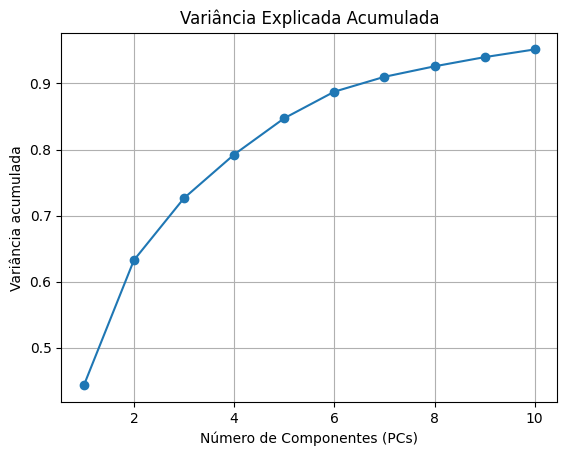

In [4]:

# Cálculo da variância acumulada
var_acum = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(range(1, len(var_acum)+1), var_acum, marker='o')
plt.title('Variância Explicada Acumulada')
plt.xlabel('Número de Componentes (PCs)')
plt.ylabel('Variância acumulada')
plt.grid(True)
plt.show()



## 5. Como interpretar os resultados
- **`X_pca.shape`**: quantas *features* restaram após o PCA (novas variáveis PC1, PC2, ...).
- **`explained_variance_ratio_`**: fração de variância que cada componente explica (importância relativa).
- **Gráfico de variância acumulada**: mostre onde a curva "dobra" para decidir um corte eficiente.
- **Trade-off**: menos componentes = mais simples/rápido; mais componentes = mais informação.



## 6. (Opcional) Usando as *features* do PCA em um modelo simples
Vamos comparar um **KNN** usando as **features originais** vs. as **features reduzidas por PCA**.
O objetivo não é bater recorde de acurácia, mas mostrar o **impacto em tempo e generalização**.


In [5]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# Sem PCA
scores_sem_pca = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')
print('KNN sem PCA — acurácia média:', scores_sem_pca.mean().round(4))

# Com PCA
scores_com_pca = cross_val_score(knn, X_pca, y, cv=cv, scoring='accuracy')
print('KNN com PCA  — acurácia média:', scores_com_pca.mean().round(4))

print('\nGanho prático: mesmo com menos features, o desempenho costuma ficar similar, às vezes melhor (menos ruído e overfitting).')


KNN sem PCA — acurácia média: 0.9666
KNN com PCA  — acurácia média: 0.9596

Ganho prático: mesmo com menos features, o desempenho costuma ficar similar, às vezes melhor (menos ruído e overfitting).



## 7. Boas práticas e dicas
- **Padronize sempre** antes do PCA (ao menos para variáveis em escalas diferentes).
- Use `n_components` como **fração de variância** (ex.: `0.90`, `0.95`) para achar o número ideal automaticamente.
- Para dados **não lineares** (texto/imagem/embeddings), considere **UMAP** para visualização e exploração.
- Após o PCA, treine e valide seu modelo com **cross-validation** para confirmar que a mudança ajudou.
